In [1]:
from pathlib import Path

import numpy as np

import noctiluca as nl

In [2]:
files = list(Path('.').glob('../data/20250327*mci*.h5'))
files

[PosixPath('../data/20250327_mci_NPFit-aGparam_U2OS.h5'),
 PosixPath('../data/20250327_mci_NPFit-aGparam_mESC.h5')]

In [3]:
i0 = len('20250327_mci_NPFit-aGparam_')
mci = {}
for f in files:
    ct = f.name[i0:(i0+4)]
    mci[ct] = nl.io.load.hdf5(f)

In [4]:
name_order = ['minflux', 'SPT 100ms', 'SPT 2s', 'SPT', 'minflux + SPT']
for ct in mci:
    ct_print = ct
    for treatment in ['ctrl', 'DRB', 'TSA', 'ICRF']:
        treatment_print = treatment
        for name in name_order:
            name_print = name
            if name == 'SPT':
                name_print = 'SPT (both)'
                
            mymci = mci[ct][treatment][name]
            keys = ['α', 'log(αΓ)'] + [key for key in mymci if 'log(σ²)' in key]
            for key in keys:
                prints = [f'{ct_print:>5s}',
                          f'{treatment_print:>5s}',
                          f'{name_print:>15s}',
                         ]
                ct_print = ''
                treatment_print = ''
                name_print = ''
                
                m, ci = mymci[key]
                val = m
                if 'log(σ²)' in key:
                    val = np.sqrt(np.exp(val)) * 1e3 # nm
                    ci  = np.sqrt(np.exp(ci)) * 1e3 # nm
                    if 'minflux' in key:
                        key = 'σ minflux'
                    else:
                        key = 'σ '+key.split(' ')[0]
                        val /= np.sqrt(2) # 2-loc
                        ci  /= np.sqrt(2)
                    
                    prints.append(f'{key:>12s}')
                    prints.append(f'{val:>5.1f} nm')
                    prints.append(f'[{ci[0]:>5.1f}, {ci[1]:>5.1f}] nm ')
                else:
                    prints.append(f'{key:>12s}')
                    prints.append(f'{val:>7.3f} ')
                    prints.append(f'[{ci[0]:>7.3f}, {ci[1]:>7.3f}]')
                        
                print(' | '.join(prints))
                
            print('-'*80)
        print('-'*80)
    print('-'*80)

 U2OS |  ctrl |         minflux |            α |   0.329  | [  0.324,   0.334]
      |       |                 |      log(αΓ) |  -5.614  | [ -5.643,  -5.585]
      |       |                 |    σ minflux |  13.8 nm | [ 13.6,  14.0] nm 
--------------------------------------------------------------------------------
      |       |       SPT 100ms |            α |   0.352  | [  0.340,   0.364]
      |       |                 |      log(αΓ) |  -5.744  | [ -5.766,  -5.722]
      |       |                 |  σ SPT-100ms |  17.3 nm | [ 16.8,  17.8] nm 
--------------------------------------------------------------------------------
      |       |          SPT 2s |            α |   0.335  | [  0.313,   0.356]
      |       |                 |      log(αΓ) |  -5.943  | [ -5.984,  -5.903]
      |       |                 |     σ SPT-2s |  26.3 nm | [ 21.0,  30.4] nm 
--------------------------------------------------------------------------------
      |       |      SPT (both) |            α

# Plot results

In [5]:
from matplotlib import pyplot as plt

In [6]:
allparams = nl.TaggedSet()
for ct in mci:
    for treatment in mci[ct]:
        for group in mci[ct][treatment]:
            for key, (m, ci) in mci[ct][treatment][group].items():
                allparams.add(m, [key, ct, treatment, group])

len(allparams)

144

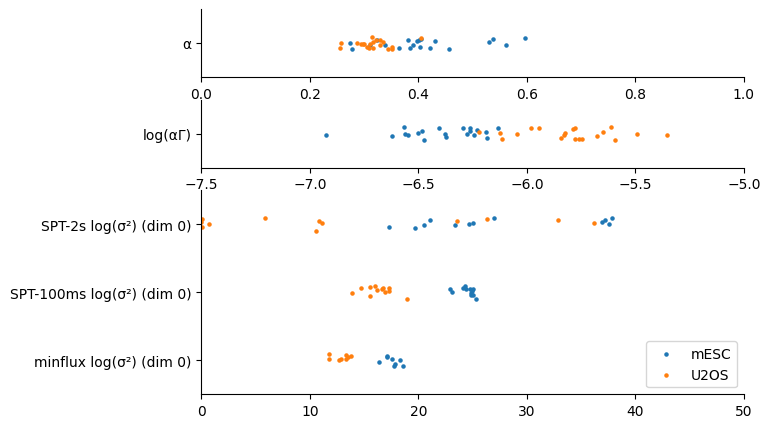

In [7]:
keys = ['α',
        'log(αΓ)',
        'minflux log(σ²) (dim 0)',
        'SPT-100ms log(σ²) (dim 0)',
        'SPT-2s log(σ²) (dim 0)',
       ]

fig, axs = plt.subplots(3, 1, figsize=[7, 5],
                        gridspec_kw={'height_ratios' : [1, 1, 3],
                                     'hspace' : 0.2,
                                    },
                       )

ax_dict = {key : axs[-1] for key in keys}
ax_dict['α'] = axs[0]
ax_dict['log(αΓ)'] = axs[1]

# color_by = ['minflux', 'SPT 100ms', 'SPT 2s', 'SPT', 'minflux + SPT']
color_by = ['mESC', 'U2OS']

ax_labels = {ax : [] for ax in axs}
for cb, color in zip(color_by, [f'C{i}' for i in range(len(color_by))]):
    for i, key in enumerate(keys):
        allparams.makeSelection([key, cb], logic=all)
        Y = np.array(allparams)
        X = 0.2*(np.random.rand(len(Y))-0.5) + i

        if 'log(σ²)' in key:
            Y = np.sqrt(np.exp(Y)) * 1e3
            if 'minflux' not in key:
                Y /= np.sqrt(2)
        
        ax = ax_dict[key]
        ax.scatter(Y, X, s=5, color=color)
        ax_labels[ax].append((i, key))
    
    ax = axs[-1]
    ax.scatter(np.inf, np.inf, s=5, color=color, label=cb)

ax = axs[-1]
ax.legend(loc='lower right')
for ax in ax_labels:
    ticks, ind  = np.unique([i   for i, key in ax_labels[ax]], return_index=True)
    labels      = np.array([key for i, key in ax_labels[ax]])[ind]
    ax.set_yticks(ticks, labels)
    ax.set_ylim([np.min(ticks)-0.5, np.max(ticks)+0.5])
    ax.set_facecolor((1, 1, 1, 0))
    
axs[0].set_xlim([0, 1])
axs[1].set_xlim([-7.5, -5])
axs[2].set_xlim([0, 50])

for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.show()